In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, make_scorer, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.pipeline import Pipeline
import time
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


/Users/n.valieva/ml_proj_spbu/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_all_seeds(seed):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
DEFAULT_RANDOM_SEED = 42
set_all_seeds(seed=DEFAULT_RANDOM_SEED)

# Задача регресии

In [54]:
X = pd.read_csv('X_reg.csv')
y = pd.read_csv('y_reg.csv')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=DEFAULT_RANDOM_SEED
)

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
models_config = {
    "LinearRegression": {
        "model": LinearRegression,
        "params": {},
        "scaled": True
    },
    "PolynomialRegression": {
        "model": LinearRegression,
        "params": {
            "degree": [2, 3]
        },
        "scaled": True
    },
    "SVR_Linear": {
        "model": SVR,
        "params": {
            "C": (1e-3, 100.0),
            "gamma": (1e-4, 1.0),
            "kernel": ["linear"]
        },
        "scaled": True
    },
    "SVR_RBF": {
        "model": SVR,
        "params": {
            "C": (1e-3, 100.0),
            "gamma": (1e-4, 1.0),
            "kernel": ["rbf"]
        },
        "scaled": True
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor,
        "params": {
            "max_depth": (3, 20),
            "min_samples_split": (2, 20),
            "min_samples_leaf": (1, 10)
        },
        "scaled": False
    },
    "RandomForest": {
        "model": RandomForestRegressor,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 20),
            "min_samples_split": (2, 20),
            "min_samples_leaf": (1, 10)
        },
        "scaled": False
    },
    "XGBoost": {
        "model": XGBRegressor,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 15),
            "learning_rate": (0.01, 0.3),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        },
        "scaled": False
    },
    "CatBoost": {
        "model": CatBoostRegressor,
        "params": {
            "depth": (3, 10),
            "learning_rate": (0.01, 0.3),
            "l2_leaf_reg": (1, 10),
            "iterations": (100, 500)
        },
        "scaled": False
    },
    "LightGBM": {
        "model": LGBMRegressor,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 15),
            "learning_rate": (0.01, 0.3),
            "num_leaves": (20, 150),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        },
        "scaled": False
    }
}

In [35]:
def run_regressor(name, cfg):
    print(f"{name}")
    ModelClass = cfg["model"]
    scaled = cfg["scaled"]
    params = cfg["params"]

    def objective(trial):
        kwargs = {}
        for k, v in params.items():
            if isinstance(v, tuple) and isinstance(v[0], (int, float)):
                if isinstance(v[0], int):
                    kwargs[k] = trial.suggest_int(k, v[0], v[1])
                else:
                    kwargs[k] = trial.suggest_float(k, v[0], v[1])
            elif isinstance(v, list):
                kwargs[k] = trial.suggest_categorical(k, v)

        if name == "PolynomialRegression":
            degree = kwargs.pop("degree")
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=degree)),
                ("reg", ModelClass(**kwargs))
            ])
        elif name == "CatBoost":
            model = ModelClass(**kwargs, random_seed=DEFAULT_RANDOM_SEED, silent=True)
        elif name == "XGBoost":
            model = ModelClass(**kwargs, random_state=DEFAULT_RANDOM_SEED, n_jobs=-1)
        else:
            model = ModelClass(**kwargs)

        Xtr = X_train_scaled if scaled else X_train
        score = cross_val_score(model, Xtr, np.ravel(y_train), cv=3,
                                scoring=make_scorer(mean_absolute_error, greater_is_better=False)).mean()
        return -score  

    start_tune = time.time()
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    tune_time = time.time() - start_tune

    best_params = study.best_params

    if name == "PolynomialRegression":
        degree = best_params.pop("degree", 2)
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree)),
            ("reg", ModelClass(**best_params))
        ])
    elif name == "CatBoost":
        model = ModelClass(**best_params, random_seed=DEFAULT_RANDOM_SEED, silent=True)
    elif name == "XGBoost":
        model = ModelClass(**best_params, random_state=DEFAULT_RANDOM_SEED, n_jobs=-1)
    else:
        model = ModelClass(**best_params)

    Xtr = X_train_scaled if scaled else X_train
    Xte = X_test_scaled if scaled else X_test

    start_train = time.time()
    model.fit(Xtr, np.ravel(y_train))
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(Xte)
    pred_time = time.time() - start_pred

    mae = mean_absolute_error(y_test, y_pred)

    return {
        "model": name,
        "mae": round(mae, 4),
        "tune_time_sec": round(tune_time, 2),
        "train_time_sec": round(train_time, 2),
        "predict_time_sec": round(pred_time, 4),
        "best_params": best_params
    }

In [ ]:
results = []
for name, cfg in models_config.items():
    res = run_regressor(name, cfg)
    results.append(res)

In [37]:
results_df = pd.DataFrame(results).sort_values(by="mae")

In [38]:
results_df

,model,mae,tune_time_sec,train_time_sec,predict_time_sec,best_params
5,RandomForest,9.0785,38.24,0.37,0.0036,"{'n_estimators': 54, 'max_depth': 8, 'min_samp..."
7,CatBoost,9.2157,21.43,0.12,0.0006,"{'depth': 4, 'learning_rate': 0.04238285460798..."
6,XGBoost,9.2172,29.05,0.23,0.0017,"{'n_estimators': 149, 'max_depth': 5, 'learnin..."
8,LightGBM,9.2627,30.95,0.34,0.0015,"{'n_estimators': 108, 'max_depth': 7, 'learnin..."
4,DecisionTree,9.6036,0.58,0.01,0.0008,"{'max_depth': 5, 'min_samples_split': 8, 'min_..."
3,SVR_RBF,10.6280,5.01,0.08,0.0296,"{'C': 28.918387049197612, 'gamma': 0.022813947..."
1,PolynomialRegression,10.7004,5.79,0.02,0.0006,{}
0,LinearRegression,11.7948,0.13,0.00,0.0000,{}
2,SVR_Linear,11.9224,12.55,0.05,0.0081,"{'C': 0.15380059507163463, 'gamma': 0.23166817..."


In [40]:
print('model', ' & ', 'mae', ' & ', 'tune_time_sec', ' & ', 'train_time_sec', ' & ', 'predict_time_sec', ' \\\\')
for _, row in results_df.iterrows():
	print(row['model'], ' & ', row['mae'], ' & ', row['tune_time_sec'], ' & ', row['train_time_sec'], ' & ', row['predict_time_sec'], ' \\\\')

model  &  mae  &  tune_time_sec  &  train_time_sec  &  predict_time_sec  \\
RandomForest  &  9.0785  &  38.24  &  0.37  &  0.0036  \\
CatBoost  &  9.2157  &  21.43  &  0.12  &  0.0006  \\
XGBoost  &  9.2172  &  29.05  &  0.23  &  0.0017  \\
LightGBM  &  9.2627  &  30.95  &  0.34  &  0.0015  \\
DecisionTree  &  9.6036  &  0.58  &  0.01  &  0.0008  \\
SVR_RBF  &  10.628  &  5.01  &  0.08  &  0.0296  \\
PolynomialRegression  &  10.7004  &  5.79  &  0.02  &  0.0006  \\
LinearRegression  &  11.7948  &  0.13  &  0.0  &  0.0  \\
SVR_Linear  &  11.9224  &  12.55  &  0.05  &  0.0081  \\


In [ ]:
# results_df.to_dict(orient='records')

In [56]:
tree = RandomForestRegressor(random_state=DEFAULT_RANDOM_SEED, n_estimators=54, max_depth=8, min_samples_split=16, min_samples_leaf=1)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

/Users/n.valieva/ml_proj_spbu/.venv/lib/python3.10/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [60]:
# y_pred_tree

In [64]:
y_pred_tree[1]

np.float64(30.57545852825653)

In [65]:
y_test.values[1]

array([29.21])

In [68]:
np.mean(y_test), np.mean(y_pred_tree)

(np.float64(45.65504273504275), np.float64(44.38754319156776))

(array([40., 90., 40., 25., 13., 12., 31., 33., 22., 37., 30., 16., 12.,
         1.,  4.,  2.,  3.,  7.,  7.,  1.,  4.,  9.,  8.,  6.,  1.,  6.,
         3.,  3.,  1.,  1.]),
 array([30.05699072, 31.96533559, 33.87368046, 35.78202533, 37.6903702 ,
        39.59871507, 41.50705994, 43.41540481, 45.32374968, 47.23209455,
        49.14043942, 51.04878429, 52.95712916, 54.86547403, 56.7738189 ,
        58.68216377, 60.59050864, 62.49885351, 64.40719838, 66.31554325,
        68.22388812, 70.13223299, 72.04057786, 73.94892273, 75.8572676 ,
        77.76561247, 79.67395734, 81.58230221, 83.49064708, 85.39899195,
        87.30733682]),
 <BarContainer object of 30 artists>)

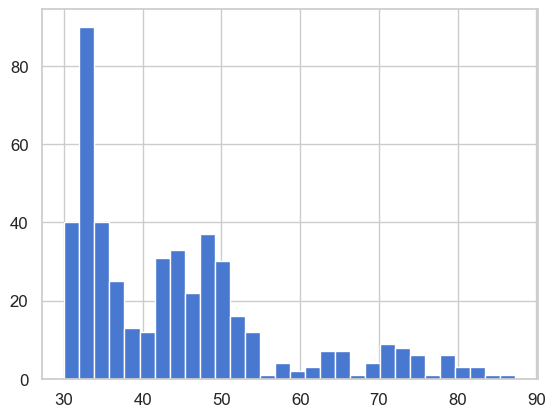

In [61]:
plt.hist(y_pred_tree, bins=30)

(array([14., 38., 42., 47., 51., 39., 24., 26., 26., 19., 22., 31., 17.,
        18.,  5.,  6.,  9.,  8.,  4.,  4.,  1.,  3.,  3.,  1.,  6.,  1.,
         0.,  0.,  0.,  3.]),
 array([ 20.39 ,  23.656,  26.922,  30.188,  33.454,  36.72 ,  39.986,
         43.252,  46.518,  49.784,  53.05 ,  56.316,  59.582,  62.848,
         66.114,  69.38 ,  72.646,  75.912,  79.178,  82.444,  85.71 ,
         88.976,  92.242,  95.508,  98.774, 102.04 , 105.306, 108.572,
        111.838, 115.104, 118.37 ]),
 <BarContainer object of 30 artists>)

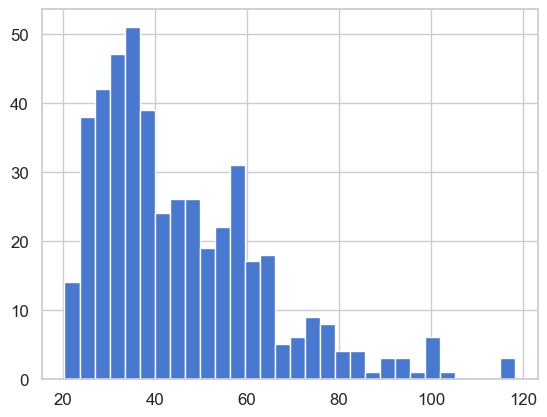

In [66]:
plt.hist(y_test, bins=30)

# Бинарная классификация

In [11]:
X = pd.read_csv('X_bin.csv')
y = pd.read_csv('y_bin.csv')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=DEFAULT_RANDOM_SEED
)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
models_config = {
    "LogisticRegression": {
        "model": LogisticRegression,
        "params": {
            "C": (1e-3, 100.0),
            "penalty": ["l2"],
            "solver": ["lbfgs"],
            "max_iter": [1000]
        },
        "scaled": True
    },
    "PolynomialRegression": {
        "model": LogisticRegression,
        "params": {
            "C": (1e-3, 100.0),
            "penalty": ["l2"],
            "solver": ["lbfgs"],
            "max_iter": [1000],
            "degree": [2]
        },
        "scaled": True
    },
    "SVM_Linear": {
        "model": SVC,
        "params": {
            "C": (1e-3, 100.0),
            "gamma": (1e-4, 1.0),
            "kernel": ["linear"]
        },
        "scaled": True
    },
    "SVM_RBF": {
        "model": SVC,
        "params": {
            "C": (1e-3, 100.0),
            "gamma": (1e-4, 1.0),
            "kernel": ["rbf"]
        },
        "scaled": True
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier,
        "params": {
            "max_depth": (3, 20),
            "min_samples_split": (2, 20),
            "min_samples_leaf": (1, 10),
            "criterion": ["gini", "entropy"]
        },
        "scaled": False
    },
    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 20),
            "min_samples_split": (2, 20),
            "min_samples_leaf": (1, 10),
            "max_features": ["sqrt", "log2"]
        },
        "scaled": False
    },
    "XGBoost": {
        "model": XGBClassifier,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 15),
            "learning_rate": (0.01, 0.3),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        },
        "scaled": False
    },
    "CatBoost": {
        "model": CatBoostClassifier,
        "params": {
            "depth": (3, 10),
            "learning_rate": (0.01, 0.3),
            "l2_leaf_reg": (1, 10),
            "iterations": (100, 500)
        },
        "scaled": False
    },
    "LightGBM": {
        "model": LGBMClassifier,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 15),
            "learning_rate": (0.01, 0.3),
            "num_leaves": (20, 150),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        },
        "scaled": False
    }
}

In [14]:
def run_model(name, cfg):
    print(f"Using {name}")
    ModelClass = cfg["model"]
    scaled = cfg["scaled"]
    params = cfg["params"]

    def objective(trial):
        kwargs = {}
        for k, v in params.items():
            if isinstance(v, tuple) and isinstance(v[0], (int, float)):
                if isinstance(v[0], int):
                    kwargs[k] = trial.suggest_int(k, v[0], v[1])
                else:
                    kwargs[k] = trial.suggest_float(k, v[0], v[1])
            elif isinstance(v, list):
                kwargs[k] = trial.suggest_categorical(k, v)
        if name == "PolynomialRegression":
            degree = kwargs.pop("degree")
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=degree)),
                ("clf", ModelClass(**kwargs, random_state=42))
            ])
        elif name == "CatBoost":
            model = ModelClass(**kwargs, random_seed=DEFAULT_RANDOM_SEED, silent=True)
        elif name == "XGBoost":
            model = ModelClass(**kwargs, random_state=DEFAULT_RANDOM_SEED, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
        else:
            model = ModelClass(**kwargs, random_state=DEFAULT_RANDOM_SEED)

        Xtr = X_train_scaled if scaled else X_train
        score = cross_val_score(model, Xtr, np.ravel(y_train), cv=3, scoring=make_scorer(f1_score)).mean()
        return score
    
    start_tune = time.time()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    tune_time = time.time() - start_tune
    best_params = study.best_params
    if name == "PolynomialRegression":
        degree = best_params.pop("degree", 2)
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree)),
            ("clf", ModelClass(**best_params, random_state=42))
        ])
    elif name == "CatBoost":
        model = ModelClass(**best_params, random_seed=DEFAULT_RANDOM_SEED, silent=True)
    elif name == "XGBoost":
        model = ModelClass(**best_params, random_state=DEFAULT_RANDOM_SEED, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
    else:
        model = ModelClass(**best_params, random_state=DEFAULT_RANDOM_SEED)

    Xtr = X_train_scaled if scaled else X_train
    Xte = X_test_scaled if scaled else X_test
    start_train = time.time()
    model.fit(Xtr, np.ravel(y_train))
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(Xte)
    pred_time = time.time() - start_pred

    f1 = f1_score(y_test, y_pred)
    return {
        "model": name,
        "f1_score": round(f1, 4),
        "tune_time_sec": round(tune_time, 2),
        "train_time_sec": round(train_time, 2),
        "predict_time_sec": round(pred_time, 4),
        "best_params": best_params
    }

In [ ]:
results = []
for name, cfg in models_config.items():
    res = run_model(name, cfg)
    results.append(res)

In [19]:
results_df = pd.DataFrame(results).sort_values(by="f1_score", ascending=False)

In [20]:
results_df

,model,f1_score,tune_time_sec,train_time_sec,predict_time_sec,best_params
4,DecisionTree,0.9543,0.46,0.01,0.0005,"{'max_depth': 5, 'min_samples_split': 14, 'min..."
7,CatBoost,0.9498,23.36,0.17,0.0006,"{'depth': 4, 'learning_rate': 0.09506174962377..."
5,RandomForest,0.9476,14.53,0.20,0.0055,"{'n_estimators': 102, 'max_depth': 20, 'min_sa..."
6,XGBoost,0.9476,14.54,0.10,0.0016,"{'n_estimators': 52, 'max_depth': 7, 'learning..."
8,LightGBM,0.9474,59.18,0.84,0.0036,"{'n_estimators': 245, 'max_depth': 13, 'learni..."
1,PolynomialRegression,0.9120,2.45,0.03,0.0005,"{'C': 0.8741551293495622, 'penalty': 'l2', 'so..."
3,SVM_RBF,0.9025,3.02,0.05,0.0092,"{'C': 99.57198012321416, 'gamma': 0.0100491841..."
2,SVM_Linear,0.7710,22.63,0.03,0.0045,"{'C': 0.18067738187821214, 'gamma': 0.58505721..."
0,LogisticRegression,0.7661,0.31,0.01,0.0001,"{'C': 11.368168193282326, 'penalty': 'l2', 'so..."


In [28]:
print('model', ' & ', 'f1_score', ' & ', 'tune_time_sec', ' & ', 'train_time_sec', ' & ', 'predict_time_sec', ' \\\\')
for _, row in results_df.iterrows():
	print(row['model'], ' & ', row['f1_score'], ' & ', row['tune_time_sec'], ' & ', row['train_time_sec'], ' & ', row['predict_time_sec'], ' \\\\')

model  &  f1_score  &  tune_time_sec  &  train_time_sec  &  predict_time_sec  \\
DecisionTree  &  0.9543  &  0.46  &  0.01  &  0.0005  \\
CatBoost  &  0.9498  &  23.36  &  0.17  &  0.0006  \\
RandomForest  &  0.9476  &  14.53  &  0.2  &  0.0055  \\
XGBoost  &  0.9476  &  14.54  &  0.1  &  0.0016  \\
LightGBM  &  0.9474  &  59.18  &  0.84  &  0.0036  \\
PolynomialRegression  &  0.912  &  2.45  &  0.03  &  0.0005  \\
SVM_RBF  &  0.9025  &  3.02  &  0.05  &  0.0092  \\
SVM_Linear  &  0.771  &  22.63  &  0.03  &  0.0045  \\
LogisticRegression  &  0.7661  &  0.31  &  0.01  &  0.0001  \\


In [26]:
# results_df.to_dict(orient='records')


In [21]:
tree = DecisionTreeClassifier(random_state=DEFAULT_RANDOM_SEED, **results_df.iloc[0]["best_params"])
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

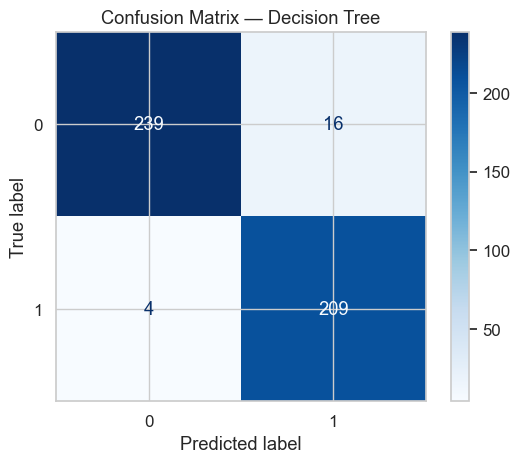

In [22]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tree)).plot(cmap='Blues')
plt.title("Confusion Matrix — Decision Tree")
plt.show()

In [25]:
confusion_matrix(y_test, y_pred_tree)

array([[239,  16],
       [  4, 209]])

In [23]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       255
           1       0.93      0.98      0.95       213

    accuracy                           0.96       468
   macro avg       0.96      0.96      0.96       468
weighted avg       0.96      0.96      0.96       468



# Многоклассовая классификация

In [42]:
def prepare_labels(y_train):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    return y_train_enc, le

In [43]:
X = pd.read_csv('X_class.csv')
y = pd.read_csv('y_class.csv')
y, _ = prepare_labels(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=DEFAULT_RANDOM_SEED
)

/Users/n.valieva/ml_proj_spbu/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
models_config = {
    "LogisticRegression": {
        "model": LogisticRegression,
        "params": {
            "C": (1e-3, 100.0),
            "penalty": ["l2"],
            "solver": ["lbfgs"],
            "max_iter": [1000]
        },
        "scaled": True
    },
    "PolynomialRegression": {
        "model": LogisticRegression,
        "params": {
            "C": (1e-3, 100.0),
            "penalty": ["l2"],
            "solver": ["lbfgs"],
            "max_iter": [1000],
            "degree": [2, 3]
        },
        "scaled": True
    },
    "SVM_Linear": {
        "model": SVC,
        "params": {
            "C": (1e-3, 100.0),
            "gamma": (1e-4, 1.0),
            "kernel": ["linear"]
        },
        "scaled": True
    },
    "SVM_RBF": {
        "model": SVC,
        "params": {
            "C": (1e-3, 100.0),
            "gamma": (1e-4, 1.0),
            "kernel": ["rbf"]
        },
        "scaled": True
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier,
        "params": {
            "max_depth": (3, 20),
            "min_samples_split": (2, 20),
            "min_samples_leaf": (1, 10),
            "criterion": ["gini", "entropy"]
        },
        "scaled": False
    },
    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 20),
            "min_samples_split": (2, 20),
            "min_samples_leaf": (1, 10),
            "max_features": ["sqrt", "log2"]
        },
        "scaled": False
    },
    "XGBoost": {
        "model": XGBClassifier,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 15),
            "learning_rate": (0.01, 0.3),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        },
        "scaled": False
    },
    "CatBoost": {
        "model": CatBoostClassifier,
        "params": {
            "depth": (3, 10),
            "learning_rate": (0.01, 0.3),
            "l2_leaf_reg": (1, 10),
            "iterations": (100, 500)
        },
        "scaled": False
    },
    "LightGBM": {
        "model": LGBMClassifier,
        "params": {
            "n_estimators": (50, 300),
            "max_depth": (3, 15),
            "learning_rate": (0.01, 0.3),
            "num_leaves": (20, 150),
            "subsample": (0.5, 1.0),
            "colsample_bytree": (0.5, 1.0)
        },
        "scaled": False
    }
}

In [46]:
def run_multiclass_model(name, cfg):
    print(f"{name}")
    ModelClass = cfg["model"]
    scaled = cfg["scaled"]
    params = cfg["params"]

    def objective(trial):
        kwargs = {}
        for k, v in params.items():
            if isinstance(v, tuple) and isinstance(v[0], (int, float)):
                if isinstance(v[0], int):
                    kwargs[k] = trial.suggest_int(k, v[0], v[1])
                else:
                    kwargs[k] = trial.suggest_float(k, v[0], v[1])
            elif isinstance(v, list):
                kwargs[k] = trial.suggest_categorical(k, v)

        if name == "PolynomialRegression":
            degree = kwargs.pop("degree")
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=degree)),
                ("clf", ModelClass(**kwargs, random_state=DEFAULT_RANDOM_SEED))
            ])
        elif name == "CatBoost":
            model = ModelClass(**kwargs, random_seed=DEFAULT_RANDOM_SEED, silent=True)
        elif name == "XGBoost":
            model = ModelClass(**kwargs, random_state=DEFAULT_RANDOM_SEED, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
        else:
            model = ModelClass(**kwargs, random_state=DEFAULT_RANDOM_SEED)

        Xtr = X_train_scaled if scaled else X_train
        score = cross_val_score(model, Xtr, np.ravel(y_train), cv=3,
                                scoring=make_scorer(f1_score, average='macro', pos_label=None)).mean()
        return score

    start_tune = time.time()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, show_progress_bar=False)
    tune_time = time.time() - start_tune

    best_params = study.best_params

    if name == "PolynomialRegression":
        degree = best_params.pop("degree", 2)
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree)),
            ("clf", ModelClass(**best_params, random_state=DEFAULT_RANDOM_SEED))
        ])
    elif name == "CatBoost":
        model = ModelClass(**best_params, random_seed=DEFAULT_RANDOM_SEED, silent=True)
    elif name == "XGBoost":
        model = ModelClass(**best_params, random_state=DEFAULT_RANDOM_SEED, n_jobs=-1, eval_metric='mlogloss')
    else:
        model = ModelClass(**best_params, random_state=DEFAULT_RANDOM_SEED)

    Xtr = X_train_scaled if scaled else X_train
    Xte = X_test_scaled if scaled else X_test

    start_train = time.time()
    model.fit(Xtr, np.ravel(y_train))
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(Xte)
    pred_time = time.time() - start_pred

    f1 = f1_score(y_test, y_pred, average='macro')

    return {
        "model": name,
        "f1_macro": round(f1, 4),
        "tune_time_sec": round(tune_time, 2),
        "train_time_sec": round(train_time, 2),
        "predict_time_sec": round(pred_time, 4),
        "best_params": best_params
    }


In [ ]:
results = []
for name, cfg in models_config.items():
    res = run_multiclass_model(name, cfg)
    results.append(res)

In [48]:
results_df = pd.DataFrame(results).sort_values(by="f1_macro", ascending=False)
results_df

,model,f1_macro,tune_time_sec,train_time_sec,predict_time_sec,best_params
7,CatBoost,0.7960,122.73,1.11,0.0008,"{'depth': 8, 'learning_rate': 0.08577069276675..."
5,RandomForest,0.7885,16.65,0.45,0.0104,"{'n_estimators': 179, 'max_depth': 18, 'min_sa..."
6,XGBoost,0.7840,118.22,0.67,0.0024,"{'n_estimators': 72, 'max_depth': 3, 'learning..."
4,DecisionTree,0.7821,0.63,0.01,0.0015,"{'max_depth': 6, 'min_samples_split': 20, 'min..."
0,LogisticRegression,0.7754,1.65,0.02,0.0002,"{'C': 4.6545051071236925, 'penalty': 'l2', 'so..."
3,SVM_RBF,0.7718,5.35,0.04,0.0221,"{'C': 23.75340246093691, 'gamma': 0.0135549042..."
8,LightGBM,0.7667,490.63,21.73,0.0321,"{'n_estimators': 235, 'max_depth': 11, 'learni..."
2,SVM_Linear,0.7602,11.95,0.04,0.0092,"{'C': 0.5652987355805901, 'gamma': 0.678120617..."
1,PolynomialRegression,0.7432,27.40,0.17,0.0006,"{'C': 1.0844933626718825, 'penalty': 'l2', 'so..."


In [51]:
print('model', ' & ', 'f1_macro', ' & ', 'tune_time_sec', ' & ', 'train_time_sec', ' & ', 'predict_time_sec', ' \\\\')
for _, row in results_df.iterrows():
	print(row['model'], ' & ', row['f1_macro'], ' & ', row['tune_time_sec'], ' & ', row['train_time_sec'], ' & ', row['predict_time_sec'], ' \\\\')

model  &  f1_macro  &  tune_time_sec  &  train_time_sec  &  predict_time_sec  \\
CatBoost  &  0.796  &  122.73  &  1.11  &  0.0008  \\
RandomForest  &  0.7885  &  16.65  &  0.45  &  0.0104  \\
XGBoost  &  0.784  &  118.22  &  0.67  &  0.0024  \\
DecisionTree  &  0.7821  &  0.63  &  0.01  &  0.0015  \\
LogisticRegression  &  0.7754  &  1.65  &  0.02  &  0.0002  \\
SVM_RBF  &  0.7718  &  5.35  &  0.04  &  0.0221  \\
LightGBM  &  0.7667  &  490.63  &  21.73  &  0.0321  \\
SVM_Linear  &  0.7602  &  11.95  &  0.04  &  0.0092  \\
PolynomialRegression  &  0.7432  &  27.4  &  0.17  &  0.0006  \\


In [ ]:
# results_df.to_dict(orient='records')

In [ ]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', **results_df.iloc[0]["best_params"]) 
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        58
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        51
           3       0.76      0.84      0.80        49
           4       0.74      0.64      0.69        58
           5       0.74      0.43      0.54        58
           6       0.45      0.77      0.57        48
           7       0.98      0.92      0.95        51
           8       0.83      0.77      0.80        39

    accuracy                           0.80       468
   macro avg       0.82      0.80      0.80       468
weighted avg       0.82      0.80      0.80       468

